In [69]:
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

path = Path('results/')

# for easy games
r_min = {
    "bigfish": 1,
    "bossfight": 0.5,
    "caveflyer": 3.5,
    "chaser": 0.5,
    "climber": 2,
    "coinrun": 5,
    "dodgeball": 1.5,
    "fruitbot": -1.5,
    "heist": 3.5,
    "jumper": 3,
    "leaper": 3,
    "maze": 5,
    "miner": 1.5,
    "ninja": 3.5,
    "plunder": 4.5,
    "starpilot": 2.5
}

# for easy games
r_max = {
    "bigfish": 40,
    "bossfight": 13,
    "caveflyer": 12,
    "chaser": 13,
    "climber": 12.6,
    "coinrun": 10,
    "dodgeball": 19,
    "fruitbot": 32.4,
    "heist": 10,
    "jumper": 10,
    "leaper": 10,
    "maze": 10,
    "miner": 13,
    "ninja": 10,
    "plunder": 30,
    "starpilot": 64
}


In [70]:
from pathlib import Path
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

def load_results(root_path: Path, scalar_names: list, load_from_disk=False):
    # If load_from_disk is True, load the DataFrame from a CSV file in the root path
    if load_from_disk:
        df = pd.read_csv(root_path / 'data.csv')
    else:
        # Create an empty list to store the data
        data = []

        # Loop over all subdirectories of the root path (which should be 'gen' or 'eff')
        for track_path in root_path.iterdir():
            # Check if the subdirectory is a directory
            if track_path.is_dir():
                # Loop over all subdirectories of the track path (which should be algorithm names)
                for method_path in track_path.iterdir():
                    # Check if the subdirectory is a directory
                    if method_path.is_dir():
                        # Print the method name
                        print(method_path.name)
                        # Loop over all subdirectories of the algorithm path (which should be experiment names)
                        for exp_path in method_path.iterdir():
                            # Check if the subdirectory is a directory
                            if exp_path.is_dir():
                                # Initialize the event accumulator and load the event file
                                event_acc = EventAccumulator(str(exp_path))
                                event_acc.Reload()

                                # Initialize an empty DataFrame
                                df = pd.DataFrame()

                                # Loop over the scalar names
                                for scalar_name in scalar_names:
                                    # Check if the scalar exists in the event file
                                    if scalar_name in event_acc.Tags()['scalars']:
                                        # Get the scalar data
                                        scalar_data = event_acc.Scalars(scalar_name)

                                        # Create a DataFrame for the scalar data
                                        scalar_df = pd.DataFrame([(x.step, x.value) for x in scalar_data], columns=['step', scalar_name])

                                        # Merge the scalar DataFrame with the main DataFrame on the 'step' column
                                        if df.empty:
                                            df = scalar_df
                                        else:
                                            df = pd.merge(df, scalar_df, on='step', how='outer')

                                # If the main DataFrame is not empty, add columns for the track, algorithm, and experiment names
                                if not df.empty:
                                    df['track'] = track_path.name
                                    df['method'] = method_path.name
                                    df['experiment'] = exp_path.name

                                    # Add the DataFrame to the list of data
                                    data.append(df)

        # Concatenate all DataFrames into a single DataFrame
        df = pd.concat(data)

        # Save the DataFrame to a CSV file in the root path
        df.to_csv(root_path / 'data.csv', index=False)


    # Further process data

    df['task'] = df['experiment'].apply(lambda x: x.split('_')[0])
    df['seed'] = df['experiment'].apply(lambda x: x.split('seed=')[1].split('_')[0])

    # rename: charts/episodic_return_mean -> train, and charts/episodic_return_mean_eval -> eval
    df = df.rename(columns={'charts/episodic_return_mean': 'train', 'charts/episodic_return_mean_eval': 'eval'})

    # for every track, task and seed, create a smoothed train column - centered rolling mean (window 8)
    df['train_smoothed'] = df.groupby(['track', 'task', 'seed'])['train'].transform(lambda x: x.rolling(8, center=True).mean())

    # create new col which is the difference between the smoothed train and eval
    # df['train_eval_ratio'] = df['train_smoothed'] / (df['eval'] + 1e-8)
    # clamp train_eval_ratio to -10,10
    # df['train_eval_ratio'] = df['train_eval_ratio'].apply(lambda x: max(-10, min(10, x)))

    # normalize returns per task for train and eval -> train_norm, eval_norm (return - r_min[task])/(r_max[task] - r_min[task])
    df['train_norm'] = (df['train'] - df['task'].apply(lambda x: r_min[x])) / (df['task'].apply(lambda x: r_max[x]) - df['task'].apply(lambda x: r_min[x]))
    df['eval_norm'] = (df['eval'] - df['task'].apply(lambda x: r_min[x])) / (df['task'].apply(lambda x: r_max[x]) - df['task'].apply(lambda x: r_min[x]))

    # smooth train_norm
    df['train_norm_smoothed'] = df.groupby(['track', 'task', 'seed'])['train_norm'].transform(lambda x: x.rolling(8, center=True).mean())
    
    # df['train_eval_ratio_norm'] = df['train_norm_smoothed'] / (df['eval_norm'] + 1e-8)
    # df['train_eval_ratio_norm'] = df['train_eval_ratio_norm'].apply(lambda x: max(1, min(10, x)))
    return df


In [71]:
# Load all data
load_from_disk = True

scalars = ['charts/episodic_return_mean', 'charts/episodic_return_mean_eval']
df = load_results(path, scalars, load_from_disk=load_from_disk)

df_gen = df[df['track'] == 'gen']
df_eff = df[df['track'] == 'eff']


In [72]:
df_gen

,step,train,eval,track,method,experiment,task,seed,train_smoothed,train_norm,eval_norm,train_norm_smoothed
0,16384,0.691589,NaN,gen,mixer-1x1,bigfish_ppo_procgen_agent=mixer_seed=0_time=16...,bigfish,0,NaN,-0.007908,NaN,NaN
1,32768,0.889764,NaN,gen,mixer-1x1,bigfish_ppo_procgen_agent=mixer_seed=0_time=16...,bigfish,0,NaN,-0.002827,NaN,NaN
2,49152,0.890511,NaN,gen,mixer-1x1,bigfish_ppo_procgen_agent=mixer_seed=0_time=16...,bigfish,0,NaN,-0.002807,NaN,NaN
3,65536,0.918519,NaN,gen,mixer-1x1,bigfish_ppo_procgen_agent=mixer_seed=0_time=16...,bigfish,0,NaN,-0.002089,NaN,NaN
4,81920,1.115385,NaN,gen,mixer-1x1,bigfish_ppo_procgen_agent=mixer_seed=0_time=16...,bigfish,0,0.994877,0.002959,NaN,-0.000131
...,...,...,...,...,...,...,...,...,...,...,...,...
218591,24920064,9.670330,NaN,gen,mixer-4x4,coinrun_ppo_procgen_agent=mixer4_1024_seed=3_t...,coinrun,3,9.398663,0.934066,NaN,0.879733
218592,24936448,9.190476,NaN,gen,mixer-4x4,coinrun_ppo_procgen_agent=mixer4_1024_seed=3_t...,coinrun,3,9.461403,0.838095,NaN,0.892281
218593,24952832,9.631579,NaN,gen,mixer-4x4,coinrun_ppo_procgen_agent=mixer4_1024_seed=3_t...,coinrun,3,NaN,0.926316,NaN,NaN
218594,24969216,9.549549,NaN,gen,mixer-4x4,coinrun_ppo_procgen_agent=mixer4_1024_seed=3_t...,coinrun,3,NaN,0.909910,NaN,NaN


In [73]:
def plot_tasks(data,x,y,hue,title):
    # for every task in the data
    sns.set_style('white')

    # on a 4x4 grid, plot the train plots for all tasks
    fig, axes = plt.subplots(4, 4, figsize=(14, 11), sharex=True)
    axes = axes.flatten()

    for i, task in enumerate(sorted(data['task'].unique())):
        # get the data for the task
        task_data = data[data['task'] == task].dropna()

        # plot the train data
        sns.lineplot(x=x, y=y, hue=hue, data=task_data, ax=axes[i], legend=True)
        axes[i].set_title(task)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].legend(loc='lower right')

        # remove the legend from all but the last plot
        if i < 15:
            axes[i].get_legend().remove()
        

    # set the title
    fig.suptitle(title, fontsize=21)

    plt.tight_layout()

    # save fig to imgs/ and make dir if needed
    if not os.path.exists('imgs'):
        os.makedirs('imgs')

    plt.savefig(f'imgs/{title}.png', dpi=300)

# Generalisation Plots

In [74]:
# build gen data

df_gen = df_gen[df_gen['seed'].isin(['0','1','2'])]
df_gen = df_gen[df_gen['method'] != 'mixer-1x1']

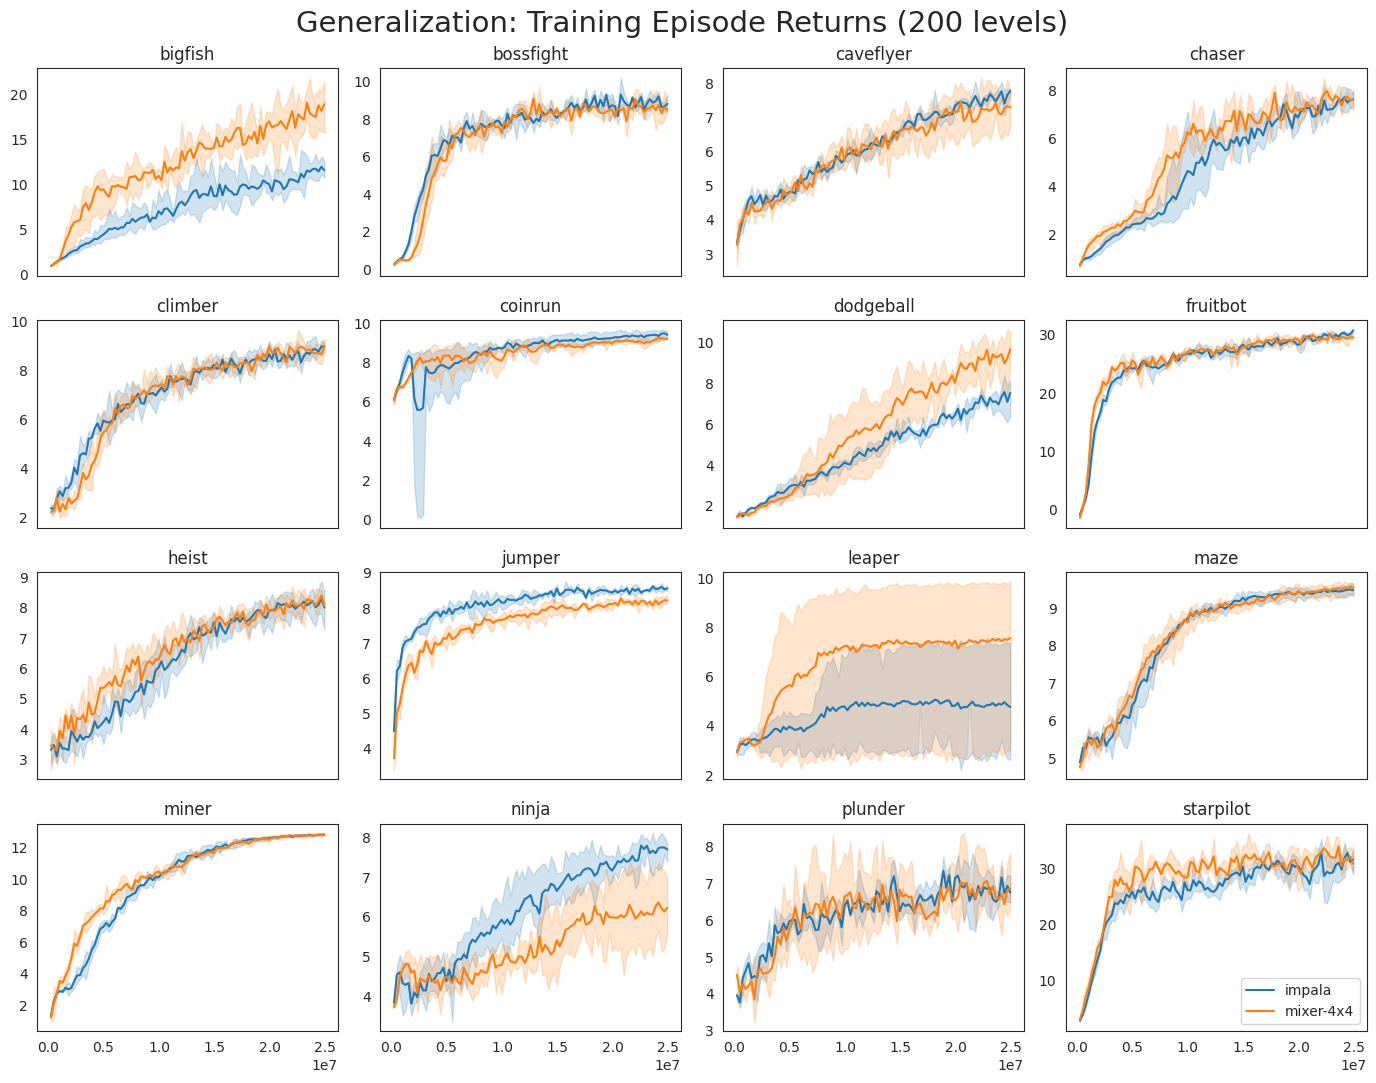

In [75]:
plot_tasks(data=df_gen, x='step', y='train_smoothed', hue='method', title='Generalization: Training Episode Returns (200 levels)')

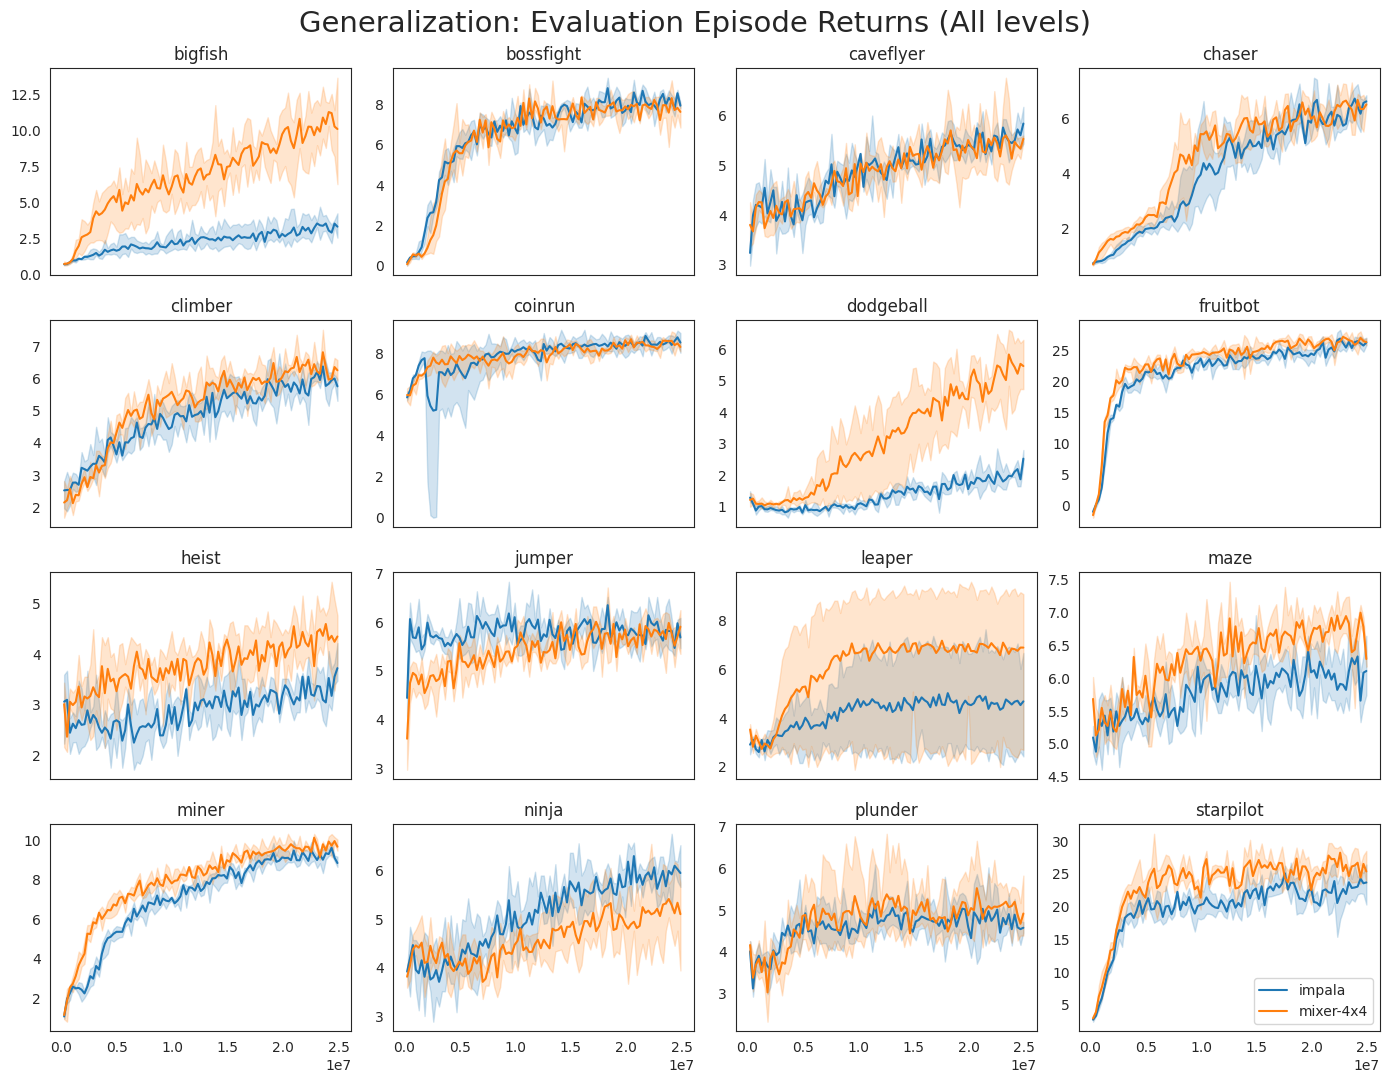

In [76]:
plot_tasks(data=df_gen, x='step', y='eval', hue='method', title='Generalization: Evaluation Episode Returns (All levels)')

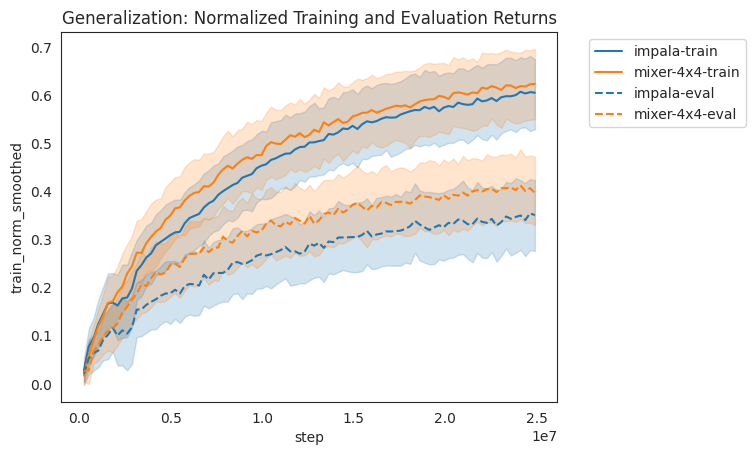

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Create a copy of the dataframe for modifying the method labels
df_mod = df_gen.dropna().copy()

# Add suffixes to method labels
df_mod['train_method'] = df_mod['method'] + '-train'
df_mod['eval_method'] = df_mod['method'] + '-eval'

# Existing line plot with modified method labels
sns.lineplot(x='step', y='train_norm_smoothed', hue='train_method', data=df_mod, legend=False)

# New line plot with the same hue and style as dotted lines, with modified method labels
sns.lineplot(x='step', y='eval_norm', hue='eval_method', data=df_mod, legend=False, linestyle='--')

# Set title - Normalized training returns
plt.title('Generalization: Normalized Training and Evaluation Returns', fontsize=12)

# Get the unique colors and labels for the legend
unique_colors = [plt.gca().get_lines()[i].get_color() for i in range(len(df_mod['method'].unique()))]
unique_labels = df_mod['method'].unique()

# Create custom legend handles and labels
legend_handles = [Line2D([0], [0], color=c, linestyle='-', label=f'{m}-train') for c, m in zip(unique_colors, unique_labels)] + \
                 [Line2D([0], [0], color=c, linestyle='--', label=f'{m}-eval') for c, m in zip(unique_colors, unique_labels)]

# Add the custom legend
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# Save the figure
plt.savefig('imgs/gen_norm.png', dpi=300)


# Efficiency Plots

In [78]:
# build eff data

df_eff = df_gen #TODO change back

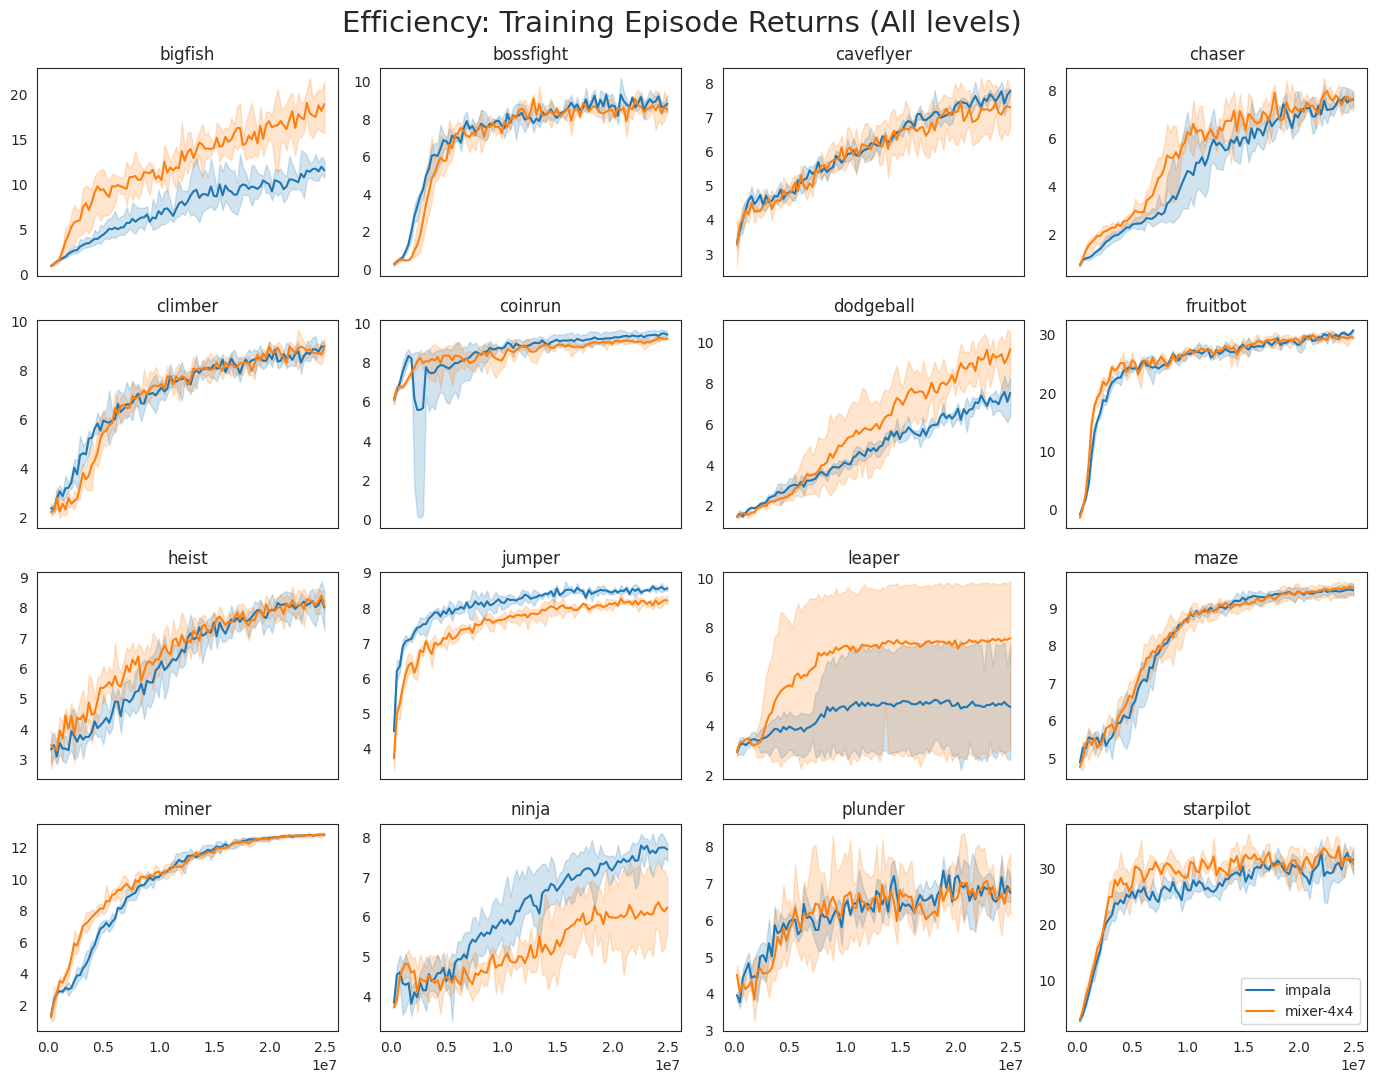

In [79]:
plot_tasks(data=df_eff, x='step', y='train_smoothed', hue='method', title='Efficiency: Training Episode Returns (All levels)')

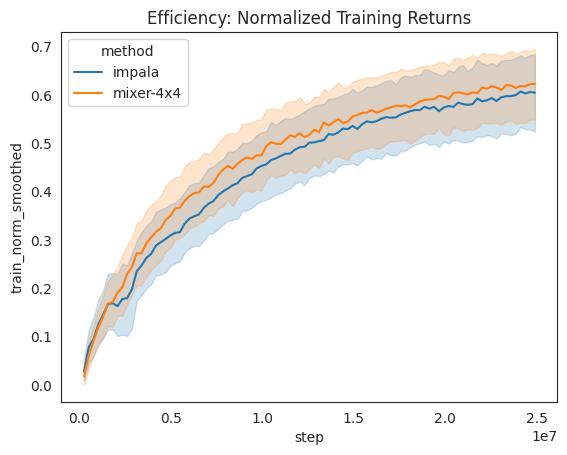

In [80]:
# plot normalized train

sns.lineplot(x='step', y='train_norm_smoothed', hue='method', data=df_eff.dropna(), legend=True)
plt.title('Efficiency: Normalized Training Returns', fontsize=12)
plt.savefig('imgs/eff_norm.png', dpi=300)